# Zasady budowania modeli deep learning

## Dlaczego Julia?

W trakcie kursu pracować będziemy w języku [Julia](https://julialang.org/). Dlaczego?

- Język skryptowy (jak Python  czy R)
- Szybkość  (jak C)
- Silny  system [typów](https://upload.wikimedia.org/wikipedia/commons/d/d9/Julia-number-type-hierarchy.svg) 
- Wbudowane  zrównoleglanie  obliczeń
- Łatwość  integracji  integracji (Python, R, C, …) 


### Literatura 

Przydatne linki:
- [Kursy Julia Academy](https://juliaacademy.com/)
- [Podręcznik Boyda i Vandenberghe](http://vmls-book.stanford.edu/)
- [Julia Express](https://github.com/bkamins/The-Julia-Express)
- [wykłady Quantitative Economics Sargenta i Stachurskiego](https://lectures.quantecon.org/jl/)
- [Julia dla Data Science](http://ucidatascienceinitiative.github.io/IntroToJulia/)
- [Think Julia](https://benlauwens.github.io/ThinkJulia.jl/latest/book.html)
- [materiały dostępne na stronie języka](https://julialang.org/learning/)

### Biblioteki

####  1. DataFrames.jl

Biblioteka [<tt>DataFrames</tt>](https://dataframes.juliadata.org/stable/) jest narzędziem pozwalającym na efektywną i wygodną pracę ze zbiorami danych. Jest implementacja znanych z <tt>R</tt> ramek danych, oferując wszystkie znane z <tt>R</tt> narzędzia, zaimplementowane w wyraźnie efektywniejszy obliczeniowo sposób. Warto zapoznać się ze szczegółowym [wprowadzeniem do <tt>DataFrames</tt> ](https://github.com/bkamins/Julia-DataFrames-Tutorial).

#### 2. Plots.jl

[Plots](https://docs.juliaplots.org/latest/tutorial/) to podstawowa bibliotka do tworzenia wykresów w Julii. Jedną z jej głównych zalet jest to, że pozwala na wykorzystanie wielu [backendów](http://docs.juliaplots.org/latest/backends/). Warto zapoznać się z [dokumenacją](http://docs.juliaplots.org/latest/) tej biblioteki.

# Modele deep learning

Gdy dane są już gotowe kolejnym krokiem jest odpowiednie zdefiniowanie modelu na którym będziemy pracować. Wykorzystamy do tego bibliotekę [flux.jl](http://fluxml.ai/):

- [Flux](http://fluxml.ai/) jest biblioteką Julii przeznaczoną do tworzenia modeli uczenia maszynowego.
- Jest w całości oparta na Julii, przez co trywialne jest jej modyfikowanie i dostosowywanie do swoich potrzeb. 
- Możliwe jest przy tym wykorzystanie wewnątrz modeli składni, funkcji i makr Julii.
- Przy czym tworzenie całkiem złożonych standardowych modeli jest intuicyjne i szybkie, zazwyczaj zajmują one jedynie kilka linijek.

### Warstwy sieci neuronowej

Jak już wspomnieliśmy wcześniej Flux jest wpełni modyfikowalny i możemy samodzielnie zdefiniować warstwy takiej sieci, korzystając np. z sigmoidalnej funkcją aktywacji:

In [1]:
@time using Flux

  1.681902 seconds (1.25 M allocations: 78.348 MiB, 7.47% gc time, 13.60% compilation time: 53% of which was recompilation)


In [2]:
W = rand(4, 8)
b = rand(4)
layer₁(x) = 1.0 ./ (1.0.+exp.(-W*x - b))

layer₁ (generic function with 1 method)

In [3]:
W

4×8 Matrix{Float64}:
 0.598487  0.0396506  0.525213   0.605258   …  0.768142   0.119159  0.658386
 0.563508  0.344984   0.610224   0.0498735     0.991968   0.93109   0.710541
 0.924617  0.401778   0.562393   0.239382      0.0446978  0.810136  0.299976
 0.639636  0.0169368  0.0533737  0.837221      0.669506   0.188654  0.103464

In [4]:
x = rand(8)
layer₁(x)

4-element Vector{Float64}:
 0.9073869021619253
 0.9143159850046292
 0.9106917602669511
 0.9060251708772546

Przy czym w przypaku najpowszechniejszych funkcji nie musimy ich samodzielnie deklarować. Flux dostarcza  najpopularniejsze funkcje aktywacji i podstawowe typy [warstw modelu](https://fluxml.ai/Flux.jl/stable/models/layers/#Basic-Layers-1):

In [5]:
layer₂(x) = σ.(W * x .+ b)
layer₂(x)

4-element Vector{Float64}:
 0.9073869021619253
 0.9143159850046292
 0.9106917602669511
 0.9060251708772546

In [6]:
layer₃ = Dense(8,4,σ)
layer₃(x)

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(8 => 4, σ)    # 36 parameters
│   summary(x) = "8-element Vector{Float64}"
└ @ Flux C:\Users\barto\.julia\packages\Flux\qZO6T\src\layers\stateless.jl:60


4-element Vector{Float32}:
 0.32529286
 0.67906857
 0.24494767
 0.5080559

Możemy zdefiniować też własne warstwy jako obiekty:

In [7]:
struct Poly
    W
    V
    b
end

Poly(in::Integer, out::Integer) =
  Poly((randn(out, in)),randn(out, in), (randn(out)))

# Overload call, so the object can be used as a function
(m::Poly)(x) = m.W * x.^2 + m.V*x .+ m.b

a = Poly(10, 5)

a(rand(10)) # => 5-element vector

5-element Vector{Float64}:
 -1.1931618166703437
  0.08618347436354734
 -1.02931416567121
  1.1427141366723055
 -1.8460469565401487

Znów, samo zdefioniowanie warstwy jako obiektu nie wystarczy do wykorzystania wszystkich funkcji Fluxa. Gdy chcemy wykorzystać wbudowane we Fluxa narzędzia do wyznaczania gradientu czy też [liczyć model na GPU](https://fluxml.ai/Flux.jl/stable/gpu/)  musimy jeszcze skorzystać z makra <tt>@functor</tt> lub [<tt>@layer</tt>](https://fluxml.ai/Flux.jl/stable/models/basics/#Flux.@layer):

In [8]:
Flux.@functor  Poly #or
Flux.@layer Poly  #or
Flux.@layer Poly trainable=(W,V)

In [9]:
using CUDA

gpu(a);

Chcąc zbudować model z więcej niż jedną warstwą musimy go odpowiednio zdefiniować:

In [10]:
Layer₁ = Dense(28^2 => 32, relu)
Layer₂ = Dense(32 => 10)
Layer₃ = softmax

softmax (generic function with 3 methods)

Funkcja <tt>Chain</tt> pozwala łączyć w łancuchy dowolne funkcje w Julii:

In [11]:
chain = Chain(x -> x^2, x-> -x)
m₁ = Chain(Layer₁ , Layer₂, Layer₃) 

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

Możemy zdefiniować model także jako złożenie funkcji:

In [12]:
m₂(x) = Layer₃(Layer₂(Layer₁(x)))

m₂ (generic function with 1 method)

In [13]:
m₃(x) = Layer₁ ∘ Layer₂ ∘ Layer₃  

m₃ (generic function with 1 method)

Albo jako potok:

In [14]:
m₄(x) = Layer₁(x) |> Layer₂  |> Layer₃ 

m₄ (generic function with 1 method)

### Funkcje kosztu i regularyzacja

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, rozdział 7](http://www.deeplearningbook.org/contents/regularization.html)

Tak jak mówiliśmy na poprzednim wykładzie nie mamy możliwości bezpośredniej optymalizacji wag $\theta$ w modelu. Do procesu uczenia musimy wykorzystać funkcję kosztu $J(\theta)$.

Funkcję straty możemy zdefiniować samodzielnie:

In [15]:
model = Dense(5,2)
x, y = rand(5), rand(2);
MSE(ŷ, y) = sum((ŷ.- y).^2)/ length(y)
loss(model,x,y) = MSE(model(x), y)
loss(model, x, y) 

0.10008948513216998

albo wykorzystać [jedną z zaimplementowanych we Fluxie](https://github.com/FluxML/Flux.jl/blob/8f73dc6e148eedd11463571a0a8215fd87e7e05b/src/layers/stateless.jl):

In [16]:
Flux.mse(model(x),y)

0.10008948513216998

Jednak samo zdefiniowanie funkcji straty nie wystarczy. Dobry model uczenia maszynowego musi mieć możliwie jak najniższy <b>błąd generalizacji</b>:

[![](https://cdn-images-1.medium.com/max/1600/1*1woqrqfRwmS1xXYHKPMUDw.png)](https://buzzrobot.com/bias-and-variance-11d8e1fee627)


Niestety sieci neuronowe mają tendencję do przeuczania się i w przypadku ich używania konieczne jest wykorzystanie odpowiedniej metody <b>regularyzacji</b>. Dzięki temu możliwe będzie zaproponowanie modelu, który będzie umiał efektywnie aproksymować dane inne niż trenujące.

Do najczęściej wykorzystywanych metod regularyzacji należą:


<b>nakładanie kar na parametry</b>:

Jeden z najczęściej wykorzystywanych sposobów regularyzacji. Polega on na nałożeniu unormowanej kary na parametry funkcji straty: 
     
$\tilde{J}(\theta) = J(\theta) + \alpha\Omega(\theta)$

Najczęściej spotykamy się z postaciami:
- $\Omega(\theta) = ||\theta||_1 = \sum_i{|\theta_i|}$     (<i>LASSO</i>,<i>regularyzacja $L_1$</i>)
- $\Omega(\theta) = ||\theta||_2^2 = \sum_i{\theta_i^2}$ (<i>regularyzacja Tichonowa</i>, <i>regresja grzbietowa</i>,<i>regularyzacja $L_2$</i>)

Ich implementacja wyglądałaby [następująco](https://fluxml.ai/Flux.jl/stable/models/regularisation/):

In [17]:
using LinearAlgebra

In [18]:
L₁(θ) = sum(abs, θ) 
L₂(θ) = sum(abs2, θ) 

L₂ (generic function with 1 method)

In [19]:
J(x,y,W) = loss(model,x ,y) + L₁(W)

J (generic function with 1 method)

In [20]:
J(x,y,W)

15.010305433966796

<b>Bagging (bootstrap aggregating)</b>:

Polega on na losowaniu ze zwracaniem $k$ próbek z wejściowego zbioru danych i szacowaniu na nich $k$  modeli, a następnie uśrednianiu ich rezultatów.

<b>Dropout</b>:

Polega na tworzeniu nowych modeli poprzez usuwanie neuronów z warstw ukrytych z prawdopodobieństwem $p$ w każdej iteracji uczenia. Niech wektor $\mu = [1,1,0,1,1,1,\dots,0,1]$ oznacza neurony wykorzystane do uczenia modelu w danej iteracji $i$. W takim wypadku procedura uczenia sprowadza się do minimalizacji wartości wyrażenia $E_\mu[J(\theta,\mu)]$ dla każdej kolejnej iteracji. Dzięki temu otrzymujemy nieobciążony estymator gradientu bez konieczności generowania i uczenia $k$ modeli tak jak w przypadku baggingu.

Dropout implementuje się we Fluxie jako [warstwę modelu](https://fluxml.ai/Flux.jl/stable/models/layers/#Normalisation-and-Regularisation-1): 

In [21]:
model = Chain(Dense(28^2 => 32, relu),
    Dropout(0.1),
Dense(32 => 10),
BatchNorm(64, relu),
softmax)

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dropout(0.1),
  Dense(32 => 10),                      # 330 parameters
  BatchNorm(64, relu),                  # 128 parameters, plus 128
  NNlib.softmax,
)         # Total: 6 trainable arrays, 25_578 parameters,
          # plus 2 non-trainable, 128 parameters, summarysize 100.922 KiB.

### Optymalizacja sieci

[Goodfellow I., Bengio Y., Courville A. (2016), Deep Learning, rozdział 8](http://www.deeplearningbook.org/contents/optimization.html)

Dobór odpowiedniego algorytmu optymalizacyjnego jest jednym z najważniejszych kroków w trakcie przygotowywania sieci neuronowej. Specyfika procesu ich uczenia powoduje, że proces optymalizacji jest podatny na wiele potencjalnych problemów, między innymi:
- złe uwarunkowanie macierzy.
- występowanie lokalnych minimów, punktów siodłowych, etc.
- zjawiska zanikającego i eksplodującego gradientu

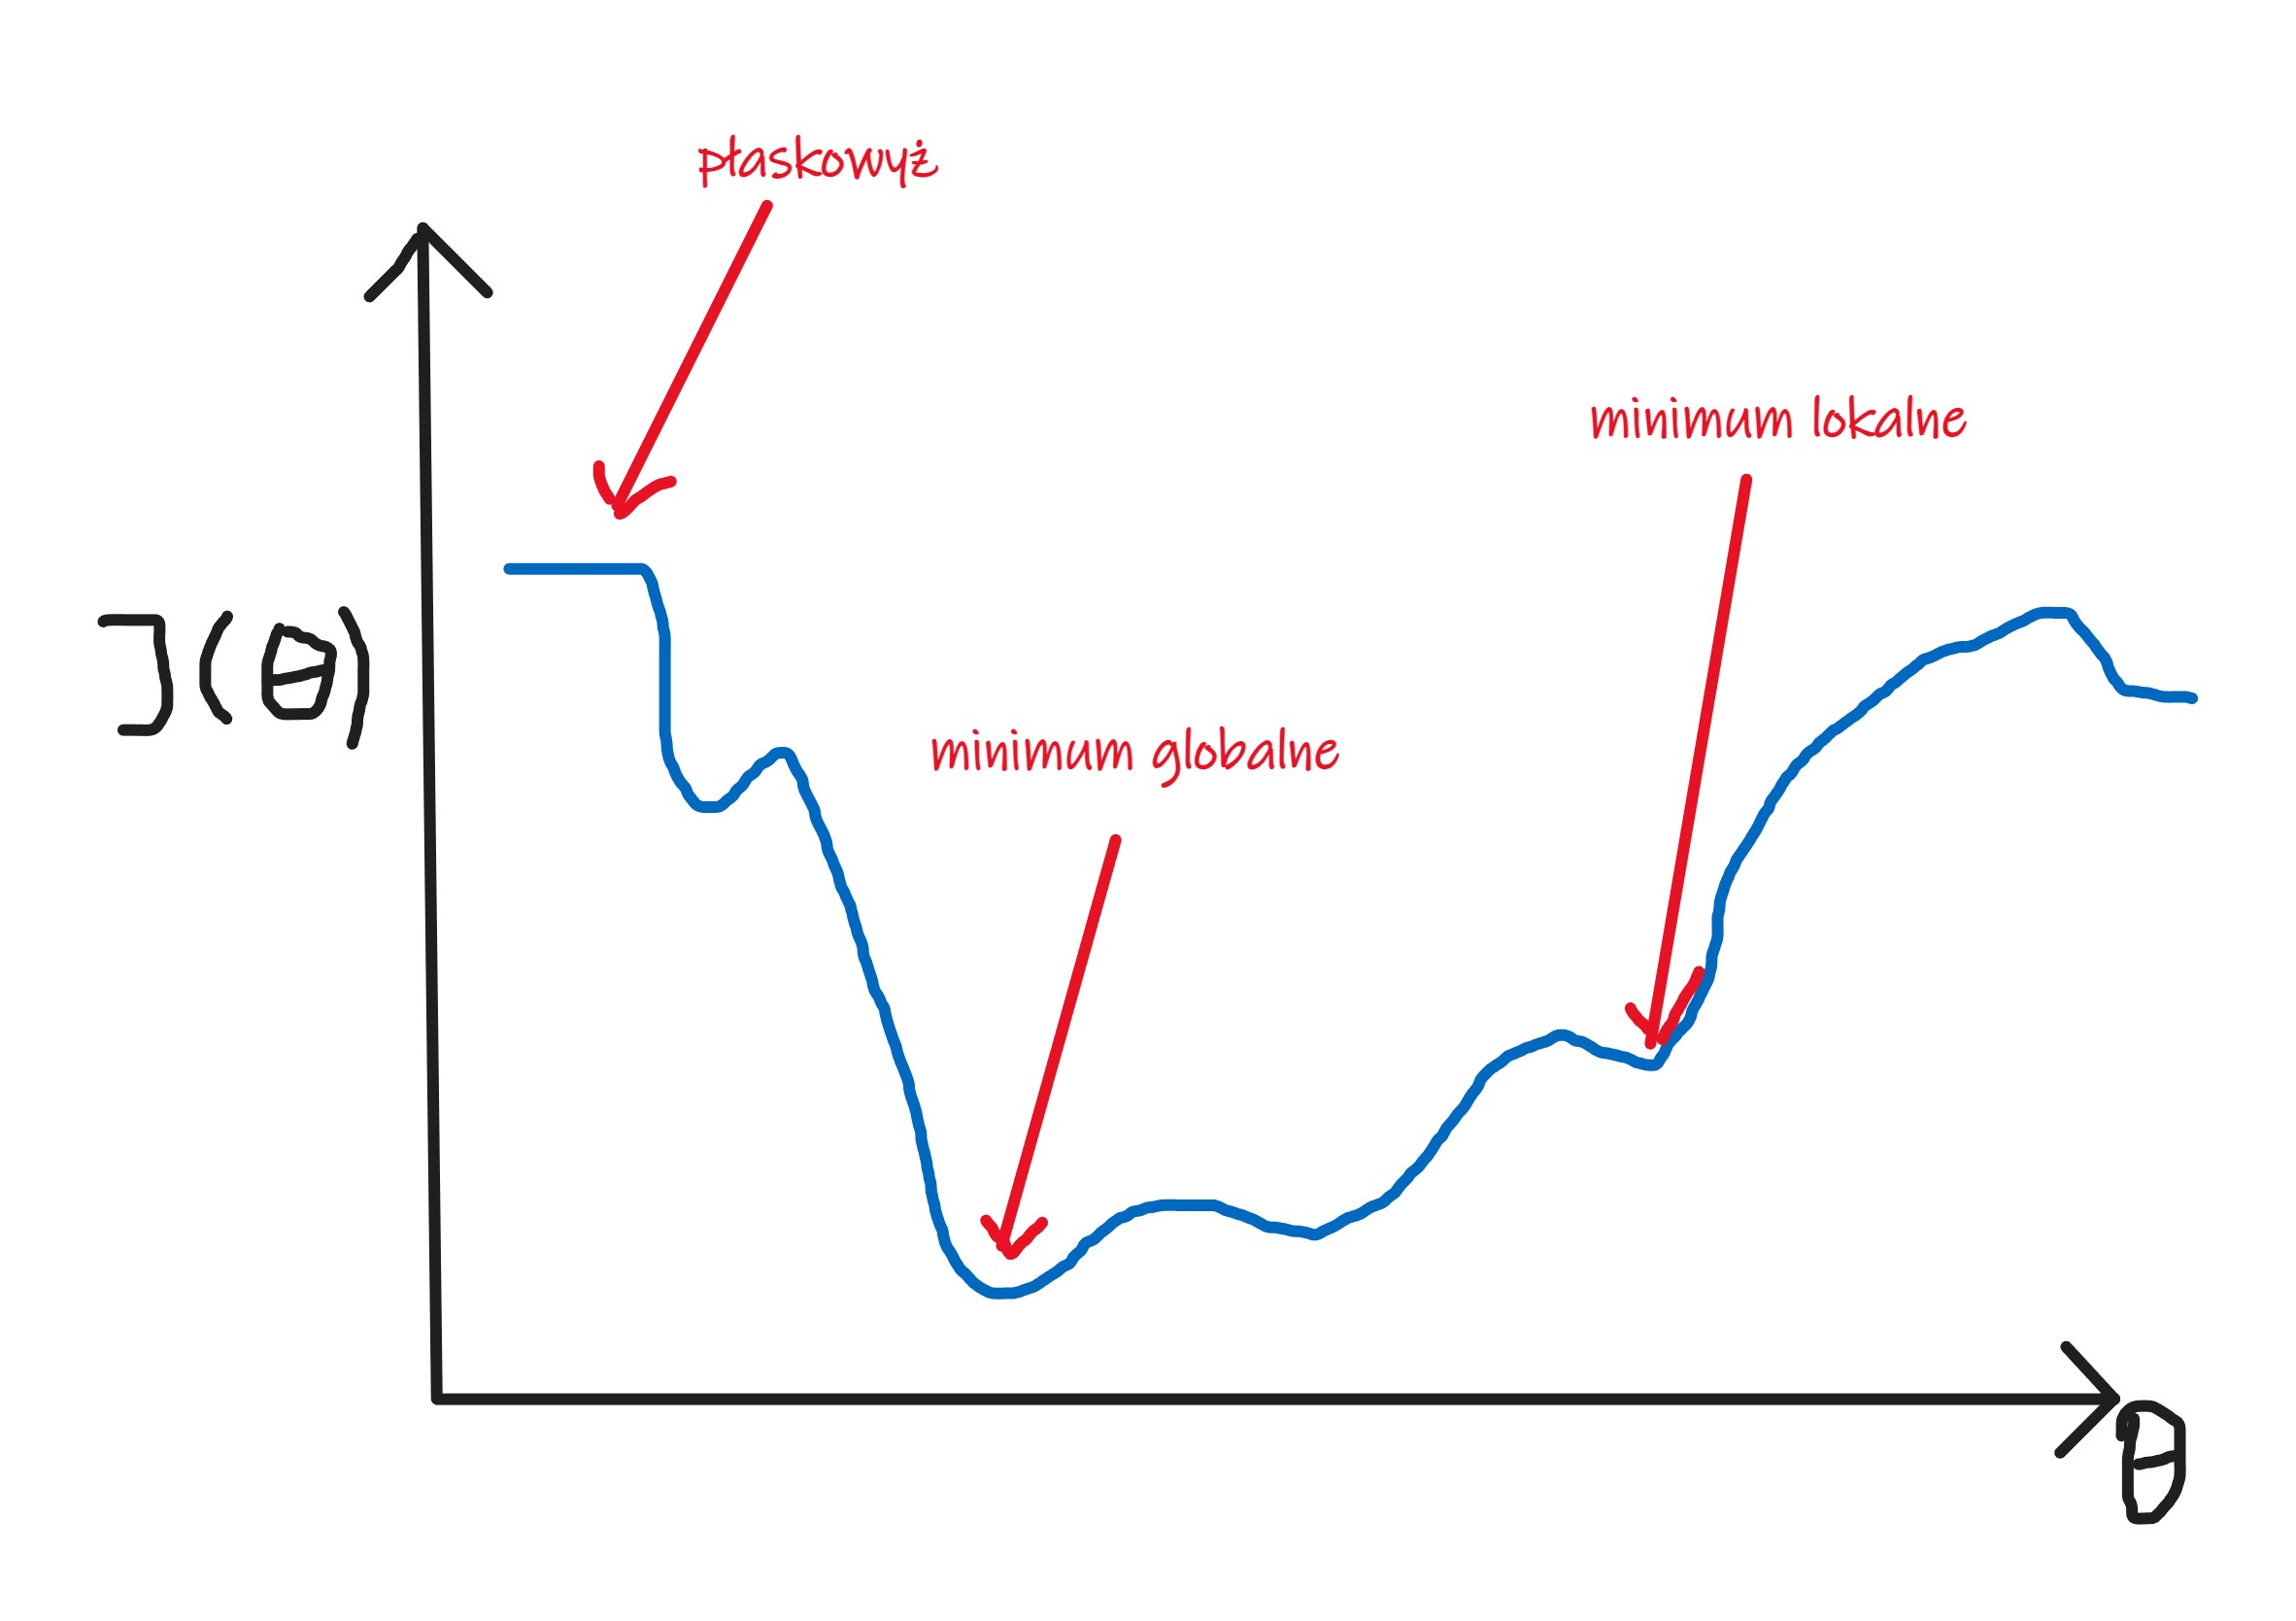

Z tego powodu istnieje wiele różnych algorytmów, które próbują przeciwdziałać wymienionym powyżej problemom. To który z nich powinien być zastosowany zależy tak naprawdę od specyfiki rozpatrywanego przypadku. Do najpopularnieszych należą:
- SGD [(Robbins & Munro 1951)](https://projecteuclid.org/download/pdf_1/euclid.aoms/1177729586)
- SGD z pędem (momentum) [(Polyak, 1964)](http://www.mathnet.ru/php/archive.phtml?wshow=paper&jrnid=zvmmf&paperid=7713&option_lang=eng)
- SGD z pędem Nesterova ([Nesterov, 1983](http://www.cis.pku.edu.cn/faculty/vision/zlin/1983-A%20Method%20of%20Solving%20a%20Convex%20Programming%20Problem%20with%20Convergence%20Rate%20O%28k%5E%28-2%29%29_Nesterov.pdf), [2005](https://www.math.ucdavis.edu/~sqma/MAT258A_Files/Nesterov-2005.pdf))
- AdaGrad (Adaptive Gradient Algorithm) [(Duchi et. al. 2011)](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
- RMSProp [(Tieleman and Hinton 2012)](https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf)
- ADAM (Adaptive Moment Estimation) [(Kingma & Ba, 2015)](https://arxiv.org/abs/1412.6980)



Flux umożliwia [wyznaczanie gradientu dowolnej funkcji](https://fluxml.ai/Flux.jl/stable/models/basics/) i przekazanie go do modelu:

In [22]:
f(x) = 3x^2 + 2x + 1

# df/dx = 6x + 2
df(x) = gradient(f, x)[1]

println(df(2)) # 14.0 

# d²f/dx² = 6
d²f(x) = gradient(df, x)[1]

println(d²f(2)) # 6.0 

14.0
6.0


Dotyczy to także dowolnych funkcji (nie tylko tych wyrażonych za pomocą metamatycznej formuły): 

In [23]:
function pow(x, n)
    r = 1
    for i = 1:n
        r *= x
    end
    return r
end

pow (generic function with 1 method)

In [24]:
pow(2,4)

16

In [25]:
gradient(x -> pow(x, 3), 5)

(75.0,)

In [26]:
pow2(x, n) = n <= 0 ? 1 : x*pow2(x, n-1)

pow2 (generic function with 1 method)

In [27]:
gradient(x -> pow2(x, 3), 5)

(75.0,)

Dzieje się tak dzięki odpowiednio skonstruowanemu mechanizmowi różniczkowania, który efektywnie wykorzystuje charakterystykę języka.  Biblioteka [<tt>Zygote.jl</tt>](https://fluxml.ai/Zygote.jl/latest/) służy do automatycznego różniczkowania w Julii. Wprowadzenie do sposobu jej działania dostępne jest [tutaj](https://github.com/MikeInnes/diff-zoo) i [tutaj](https://arxiv.org/pdf/1810.07951.pdf).

### Automatyczne różniczkowanie

Kluczowym elementem poprawnie działającej biblioteki do uczenia maszynowego jest odpowiedni algorytm wyznaczający gradient funkcji. Jak wiemy z poprzednich zajęć naiwne wyznaczanie gradientu za pomocą definicji pochodnej:
$$\frac{df}{dx} = \lim_{h \to 0}\frac{f(x_0 +h) - f(x_0)}{h}$$
nie jest efektywne numerycznie. W jaki sposób możemy wyznaczać wartości pochodnych?

Okazuje się, że każda, nawet najbardziej skomplikowana funkcja, którą liczymy jest niczym innym niż złożeniem podstawowych operacji arytmetycznych i kilku bazowych funkcji (sin,cos,log,etc.).  Znając podstawowe reguły wyliczania tych pochodnych możemy w efektywny sposób wyznaczyć wartość pochodnej korzystając z reguły łańcuchowej:

$$
\frac{dy}{dx} = \frac{dy_1}{dx}*\frac{dy_2}{dy_1}*\dots*\frac{dy_{n-1}}{dy_{n-2}}*\frac{dy}{dy_{n-1}}
$$

Różniczkowanie można wykonać na dwa sposoby:

- <b>do przodu</b> zaczynamy ze znaną wartością $\frac{dy_0}{dx} = \frac{dx}{dx} = 1$. Następnie wyznaczamy wartość dla kolejnej instrukcji  $\frac{dy_1}{dx} = \frac{d_1}{dx} = 1$ i następnie:$\frac{dy_{i+1}}{dy_i}$, aż otrzymamy pełny łańcuch.

- <b>do tyłu</b> zaczynamy ze znaną wartością  $\frac{dy}{dy_n} = \frac{dy}{dy} = 1$. Następnie wyznaczamy wartości: $\frac{dy}{dy_n}$, $\frac{dy}{dy_{n-1}}$, ... $\frac{dy}{dy_1}$, $\frac{dy}{dx}$.  

## Zygote.jl

De facto całe działanie biblioteki <tt>Zygote</tt> opiera się na dwóch kluczowych elementach: makrze <tt>@adjoint</tt> i funkcji <tt>pullback</tt>. 

<tt>pullback</tt> zwraca dwa wyniki, wartość oryginalnej funkcji $y = f(x)$ i wyrażenie $\mathcal{B}(\overline{y}) =  \overline{y}  \frac{dy}{dx}$, gdzie $\overline{y} = \frac{dl}{dy}$ jest parametrem, który musimy zdefiniować dla dowolnej funkcji $l$.  

In [28]:
using Zygote

In [29]:
y, back = Zygote.pullback(sin, π);

In [30]:
y

0.0

In [31]:
back(1)

(-1.0,)

W szczególności funkcja <tt>gradient</tt> zakłada, że  $l = y = f(x)$ i $\overline{y} = \frac{dy}{dl} = 1$:

In [32]:
gradient(sin,π) == back(1)

true

Makro <tt>@adjoint</tt> pozwala nam w dowolny sposób modyfikować działanie mechanizmu wyznaczającego pochodne:

In [33]:
using Zygote: @adjoint

In [34]:
minus(a,b) = a - b

minus (generic function with 1 method)

In [35]:
gradient(minus,2,3)

(1.0, -1.0)

In [36]:
minus2(a,b) = a - b

minus2 (generic function with 1 method)

In [37]:
@adjoint minus2(a,b) = minus2(a,b), c̄ -> (nothing, -b^2)

In [38]:
gradient(minus2,2,3)

(nothing, -9.0)

 Flux ponadto posiada zdefiniowane [podstawowe algorytmy optymalizacyjne](https://fluxml.ai/Flux.jl/stable/training/optimisers/):

In [39]:
opt_state = Flux.setup(Adam(0.0001), model)

(layers = ((weight = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (p = (), dims = (), active = (), rng = ()), (weight = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam(0.0001, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

### Uczenie modelu

Flux jest zdolny do kontrolowania całej procedury uczenia, nie musimy robić tego samodzielnie. Służy do tego funkcja <tt>train!</tt>:

Warto jednak zaznaczyć, że pozwala ona na uczenie jedynie przez pojedynczą epokę. Aby móc kontynuować proces uczenia dalej musimy w odpowiedni sposób przygotować nasz kod, zazwyczaj wykorzystując do tego pętlę for:

## Przykład

In [40]:
using Flux, Statistics
using Base.Iterators: repeated
using MLDatasets: MNIST, convert2image
using Images

Zacznijmy od podstaw, wczytajmy i opracujmy zbiór danych na którym będziemy pracowali:

In [41]:
#ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

In [42]:
train_set = MNIST(:train)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

Obejrzyjmy przykładowy obraz:

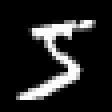

In [43]:
convert2image(MNIST,train_set.features)[:,:,1]

In [44]:
X = reshape(float.(train_set.features),size(train_set.features,1) * size(train_set.features,2),
    size(train_set.features,3))

784×60000 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0

In [45]:
Y = Flux.onehotbatch(train_set.targets, 0:9) 

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  1  ⋅  1     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

Analogicznie, wczytajmy dane testowe:

In [46]:
test_set = MNIST(:test)

#reshape data
tX = reshape(float.(test_set.features),size(train_set.features,1) * size(train_set.features,2) ,
    size(test_set.features,3))

# One-hot-encode the labels
tY = Flux.onehotbatch(test_set.targets, 0:9);

Podzielmy dane na minibatche:

In [47]:
batch_size = 256

loader = Flux.DataLoader((X, Y), batchsize=batch_size, shuffle=true);

Zdefiniujmy model:

In [48]:
m = Chain(
  Dense(28^2 => 32, relu),
  Dense(32 => 10),
  softmax) 

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

Jako funkcję straty wykorzystamy binarną entropię krzyżową (<b> binary cross-entropy </b>, <b>log-loss</b>). Jej wzór to:

$$ H_p(q) = - \sum_{i=1}^N {y_i log(p(y_i)) + (1 - y_i) log(p(1 -y_i))}$$

In [49]:
loss(m, x, y) = Flux.crossentropy(m(x), y)

accuracy(m, x, y) = mean(Flux.onecold(m(x)) .== Flux.onecold(y))

evalcb = () -> @show(loss(X, Y))
            
opt_state = Flux.setup(Adam(), m)

accuracy(m, X, Y)

0.09195

I zacznijmy proces uczenia:

In [50]:
 for epoch in 1:5
    Flux.train!(loss, m, loader, opt_state)
    @info "Epoch $epoch accuracy = $(accuracy(m, tX, tY))"
end

[ Info: Epoch 1 accuracy = 0.9094
[ Info: Epoch 2 accuracy = 0.9271
[ Info: Epoch 3 accuracy = 0.932
[ Info: Epoch 4 accuracy = 0.941
[ Info: Epoch 5 accuracy = 0.9436


Otrzymane wyniki możemy zapisywać korzystając z biblioteki [<tt>BSON</tt>](https://github.com/JuliaIO/BSON.jl):

In [51]:
using BSON

In [52]:
s = Flux.state(m)
BSON.@save "MNIST.bson" s

i oczywiście wczytywać:

In [53]:
m = Chain(
  Dense(28^2 => 32, relu),
  Dense(32 => 10),
  softmax) 

BSON.@load "MNIST.bson" s

Flux.loadmodel!(m, s)

accuracy(m, tX, tY)

0.9436

lub biblioteki [JLD2](https://github.com/JuliaIO/JLD2.jl):

In [54]:
using JLD2

jldsave("MNIST.jld2"; model = Flux.state(m))

In [55]:
m = Chain(
  Dense(28^2 => 32, relu),
  Dense(32 => 10),
  softmax) 

s = JLD2.load("MNIST.jld2", "model")

Flux.loadmodel!(m, s)

Chain(
  Dense(784 => 32, relu),               # 25_120 parameters
  Dense(32 => 10),                      # 330 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 25_450 parameters, 99.664 KiB.

Ostatecznie powinniśmy przyjrzeć się wynikom:

In [56]:
# Test set accuracy
accuracy(m, tX, tY)

0.9436

### Strojenie hiperparametrów

Sieć neuronowa potrafi zoptymalizować jedynie wagi $\theta$ funkcji liniowych wykorzystanych do budowy modelu. Pozostałe parametry (funkcje aktywacji, metoda regularyzacji, stopa uczenia, etc.) muszą być przyjęte z góry. Dobrać je można na kilka różnych sposobów:
- wzorując się na literaturze
- zgadując parametry
- tworząc model [zdolny do nauczenia się optymalnej metody uczenia](https://arxiv.org/abs/2004.05439)
- przeszukując odpowiednio przestrzeń hiperparametrów

## Dodatkowa praca domowa

1. Dokonaj strojenia hiperparametrów sieci omawianej na wykładzie. Sprobuj znaleźć taką, która zapewnia wyższą trafność predykcji (powyżej 95%) <b>(7 punktów)</b>.
2. W trakcie zajęć mówiliśmy o liczbach dualnych, czyli liczbach postaci $z = a + \epsilon b$, gdzie $a,b \in \mathbb{R}$ a  $\epsilon^2 = 0$. Dla dowolnego wielomanu  postaci $f(x) = a_0 + a_1x + a_2x^2 + \dots + a_nx^n$ wartość takiego wielomianu dla liczby dualnej $z$ jest równa: $f(z) = f(a) + bf'(a)\epsilon$. Pokaż, że tak jest naprawdę <b>(3 punktów)</b>. 